In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=a97c28816f517c5499f73275d6c72dda9b6a208460c63bfa8776b196519464e5
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.sql.functions import col, to_date, year, month, avg, variance, expr, percentile_approx, abs, quarter, count, when
from scipy.stats import norm

spark = SparkSession.builder.getOrCreate()

In [ ]:
csv_path = "/content/drive/MyDrive/Big_Data/Project_1/Data/2010/*.csv"
df = spark.read.csv(csv_path, header = False, sep = '|', inferSchema = True)

In [ ]:
parquet_path = "/content/drive/MyDrive/Big_Data/Project_1/Data/2010/merged_2010.parquet"
df.write.parquet(parquet_path, mode= 'overwrite')

In [ ]:
csv_path = "/content/drive/MyDrive/Big_Data/Project_1/Data/2011/*.csv"
df1 = spark.read.csv(csv_path, header = False, sep = "|", inferSchema = True)
# df1.show()

In [ ]:
parquet_path = "/content/drive/MyDrive/Big_Data/Project_1/Data/2011/merged_2011.parquet"
df1.write.parquet(parquet_path, mode= 'overwrite')

In [ ]:
column_names = [
    "ref_pool_id",
    "loan_id",
    "report_period",
    "channel",
    "seller_name",
    "servicer_name",
    "master_servicer",
    "orig_int_rate",
    "curr_int_rate",
    "orig_upb",
    "upb_at_issuance",
    "curr_actual_upb",
    "orig_loan_term",
    "orig_date",
    "first_pay_date",
    "loan_age",
    "rem_months_legal_mat",
    "rem_months_mat",
    "maturity_date",
    "orig_ltv",
    "orig_cltv",
    "num_borrowers",
    "dti",
    "borrower_credit_score_orig",
    "co_borrower_credit_score_orig",
    "first_time_buyer",
    "loan_purpose",
    "property_type",
    "num_units",
    "occupancy_status",
    "property_state",
    "msa",
    "zip_code",
    "mortgage_ins_pct",
    "amort_type",
    "prepay_penalty_ind",
    "io_loan_ind",
    "io_first_prin_int_pay_date",
    "months_to_amort",
    "curr_loan_delinq_status",
    "loan_payment_history",
    "mod_flag",
    "mortgage_ins_cancel_ind",
    "zero_balance_code",
    "zero_balance_date",
    "upb_at_removal",
    "repurchase_date",
    "scheduled_prin_curr",
    "total_prin_curr",
    "unscheduled_prin_curr",
    "last_paid_installment_date",
    "foreclosure_date",
    "disposition_date",
    "foreclosure_costs",
    "prop_pres_repair_costs",
    "asset_recovery_costs",
    "misc_holding_expenses",
    "holding_taxes",
    "net_sale_proceeds",
    "credit_enhancement_proceeds",
    "repurchase_make_whole_proceeds",
    "other_foreclosure_proceeds",
    "non_interest_bearing_upb",
    "principal_forgiveness_amt",
    "orig_list_start_date",
    "orig_list_price",
    "curr_list_start_date",
    "curr_list_price",
    "borrower_credit_score_at_issuance",
    "co_borrower_credit_score_at_issuance",
    "borrower_credit_score_curr",
    "co_borrower_credit_score_curr",
    "mortgage_ins_type",
    "servicing_activity_ind",
    "curr_period_mod_loss_amt",
    "cumulative_mod_loss_amt",
    "curr_period_credit_event_net_gain_loss",
    "cumulative_credit_event_net_gain_loss",
    "special_elig_program",
    "foreclosure_prin_writeoff_amt",
    "relocation_mortgage_ind",
    "zero_balance_code_change_date",
    "loan_holdback_ind",
    "loan_holdback_effective_date",
    "delinquent_accrued_interest",
    "property_valuation_method",
    "high_balance_loan_ind",
    "arm_initial_fixed_rate_period_ind",
    "arm_product_type",
    "initial_fixed_rate_period",
    "int_rate_adj_freq",
    "next_int_rate_adj_date",
    "next_payment_change_date",
    "index",
    "arm_cap_structure",
    "initial_int_rate_cap_up_pct",
    "periodic_int_rate_cap_up_pct",
    "lifetime_int_rate_cap_up_pct",
    "mortgage_margin",
    "arm_balloon_ind",
    "arm_plan_num",
    "borrower_assistance_plan",
    "hltv_refinance_option_ind",
    "deal_name",
    "repurchase_whole_proceeds",
    "alt_delinq_resolution",
    "alt_delinq_resolution_count",
    "total_deferral_amt",
    "payment_deferral_mod_event_ind",
    "interest_bearing_upb"
]

print(f"Total number of columns: {len(column_names)}")

Total number of columns: 110


In [ ]:
column_renamings = [col(f"_c{i}").alias(name) for i, name in enumerate(column_names)]

df_10 = spark.read.parquet("/content/drive/MyDrive/Fall 24 (sem 3)/Big data/Project 1/merged_2010.parquet")

# Apply the renamings to your DataFrame
df_10 = df_10.select(*column_renamings)

In [ ]:
df_11 = spark.read.parquet("/content/drive/MyDrive/Fall 24 (sem 3)/Big data/Project 1/merged_2011.parquet")
df_11 = df_11.select(*column_renamings)

combined_df = df_10.union(df_11)

# Inspecting the average FICO across the two years.

The average borrower FICO score for 2010 is: 764.38
The average co borrower FICO score for 2010 is: 771.49
The average borrower FICO score for 2011 is: 765.43
The average co borrower FICO score for 2011 is: 772.57


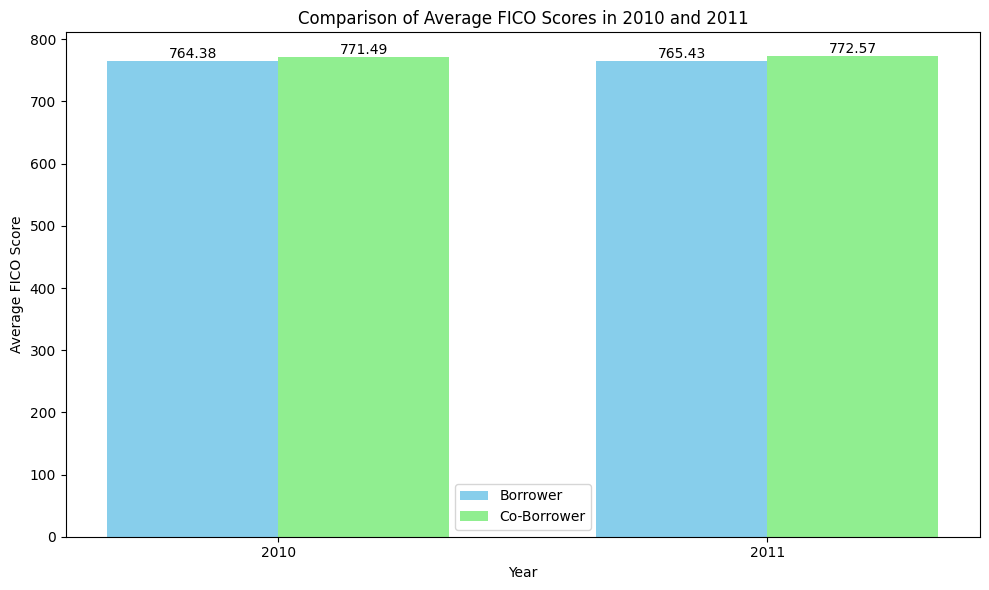

In [ ]:
subset_df_10 = df_10.select("loan_id", "seller_name", "servicer_name", "borrower_credit_score_orig", "co_borrower_credit_score_orig")
subset_df_11 = df_11.select("loan_id", "seller_name", "servicer_name", "borrower_credit_score_orig", "co_borrower_credit_score_orig")

borrower_avg_fico_2010 = subset_df_10.select(F.avg("borrower_credit_score_orig")).first()[0]
co_borrower_avg_fico_2010 = subset_df_10.select(F.avg("co_borrower_credit_score_orig")).first()[0]

print(f"The average borrower FICO score for 2010 is: {borrower_avg_fico_2010:.2f}")
print(f"The average co borrower FICO score for 2010 is: {co_borrower_avg_fico_2010:.2f}")

borrower_avg_fico_2011 = subset_df_11.select(F.avg("borrower_credit_score_orig")).first()[0]
co_borrower_avg_fico_2011 = subset_df_11.select(F.avg("co_borrower_credit_score_orig")).first()[0]

print(f"The average borrower FICO score for 2011 is: {borrower_avg_fico_2011:.2f}")
print(f"The average co borrower FICO score for 2011 is: {co_borrower_avg_fico_2011:.2f}")

years = ['2010', '2011']
borrower_scores = [borrower_avg_fico_2010, borrower_avg_fico_2011]
co_borrower_scores = [co_borrower_avg_fico_2010, co_borrower_avg_fico_2011]


bar_width = 0.35
r1 = np.arange(len(years))
r2 = [x + bar_width for x in r1]


plt.figure(figsize=(10, 6))
plt.bar(r1, borrower_scores, color='skyblue', width=bar_width, label='Borrower')
plt.bar(r2, co_borrower_scores, color='lightgreen', width=bar_width, label='Co-Borrower')


plt.xlabel('Year')
plt.ylabel('Average FICO Score')
plt.title('Comparison of Average FICO Scores in 2010 and 2011')
plt.xticks([r + bar_width/2 for r in range(len(years))], years)


def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

add_value_labels(plt.bar(r1, borrower_scores, color='skyblue', width=bar_width))
add_value_labels(plt.bar(r2, co_borrower_scores, color='lightgreen', width=bar_width))

plt.legend()

plt.tight_layout()
plt.show()

In 2010, the average borrower FICO score was 764.38, and the co-borrower score was 771.49. In 2011, both scores increased slightly, with borrower FICO at 765.43 and co-borrower FICO at 772.57. Co-borrowers had consistently higher FICO scores, and overall credit scores remained stable across both years. It depicts that the quality of borrower's and co-borrower's credit scores who took loans have been improved slightly from 2010-11.

# Inspection of the monthly delinquency rates for 30, 60 and 90 days past due and how they vary by loan term.



1. Data Preparation:
  - Columns related to loan origination date, loan term, and current delinquency status were selected.
  - A user-defined function (UDF) was applied to convert integer loan dates to a standard date format.
2. Loan Term Grouping:
  - Loans were grouped into categories based on their original loan term: <= 15 years, 16-30 years, and > 30 years.
3. Delinquency Categorization:
  - A UDF was used to categorize loans into different delinquency statuses: 30 days, 60 days, 90 days, and 90+ days past due.
4. Calculating Delinquency Rates:
  - The total number of loans per month and the number of delinquent loans by category were counted.
  - The delinquency rate was calculated as the ratio of delinquent loans to total loans for each month, loan term group, and delinquency category.
5. Sorting:
  - The results were sorted by month, loan term group, and delinquency category for easier interpretation.
6. Visualization:
  - The delinquency rates for different months and loan terms are visualized using a stacked bar chart. Each bar shows the delinquency rates for the three categories (30, 60, and 90 days delinquent) across the two loan term groups (≤ 15 years and 16-30 years).
  - The delinquency rate is presented as a percentage on the y-axis, and each category is color-coded for clarity.

In [ ]:

def int_to_date(int_date):
    if int_date is None:
        return None
    month = int_date // 10000
    year = int_date % 10000
    return f"{year:04d}-{month:02d}"


delinq_cols = ["orig_date", "orig_loan_term", "curr_loan_delinq_status"]

delinq_df = combined_df.select(*delinq_cols)

# Convert orig_date to date format
int_to_date_udf = F.udf(int_to_date, StringType())

# Apply the UDF to the orig_date column
delinq_df = delinq_df.withColumn("orig_date", F.to_date(int_to_date_udf(F.col("orig_date"))))
delinq_df = delinq_df.withColumn("month", F.date_format(F.col("orig_date"), "yyyy-MM"))
delinq_df = delinq_df.withColumn("year", F.year(F.col("orig_date")))
delinq_df = delinq_df.filter(F.col("year").isin([2010, 2011]))

# Ensure orig_loan_term is integer
delinq_df = delinq_df.withColumn("orig_loan_term", F.col("orig_loan_term").cast(IntegerType()))


# Group loans by term
delinq_df = delinq_df.withColumn("loan_term_group",
                   F.when(F.col("orig_loan_term") <= 180, "<= 15 years")
                    .when(F.col("orig_loan_term") <= 360, "16-30 years")
                    .otherwise("> 30 years"))

# Function to categorize delinquency
def categorize_delinquency(delinq_status):
    if delinq_status is None or delinq_status == "":
        return "Removed"
    if delinq_status == "XX":
        return "Unknown"

    delinq_int = int(delinq_status)

    if delinq_int == 0:
        return "Current"
    elif delinq_int <= 30:
        return "30 days"
    elif delinq_int <= 60:
        return "60 days"
    elif delinq_int <= 90:
        return "90 days"
    else:
        return "90+ days"

categorize_delinquency_udf = F.udf(categorize_delinquency, StringType())

# Add delinquency category column
delinq_df = delinq_df.withColumn("delinq_category", categorize_delinquency_udf(F.col("curr_loan_delinq_status")))

# Total number of loans per month
total_loans_by_month = delinq_df.groupBy("month", "loan_term_group").count().withColumnRenamed("count", "total_loans")

# Delinquent loans by category, month, and loan term (renaming the count column)
delinquent_loans = delinq_df.groupBy("month", "loan_term_group", "delinq_category").count().withColumnRenamed("count", "delinquent_loans")

# Group loans by term
delinq_df = delinq_df.withColumn("loan_term_group",
                   F.when(F.col("orig_loan_term") <= 180, "<= 15 years")
                    .when(F.col("orig_loan_term") <= 360, "16-30 years")
                    .otherwise("> 30 years"))

# Join and calculate delinquency rate
delinquency_rate_df = delinquent_loans.join(total_loans_by_month,
                                            on=["month", "loan_term_group"],
                                            how="left").withColumn(
                                                "delinquency_rate",
                                                F.col("delinquent_loans") / F.col("total_loans")
                                            )

# Filter for 30, 60, and 90-day delinquency rates
delinq_df = delinquency_rate_df.filter(F.col("delinq_category").isin(["30 days", "60 days", "90 days"]))

# Define sorting logic for loan_term_group
delinq_df = delinq_df.withColumn(
    "Loan Term Group",
    F.when(F.col("loan_term_group") == "<= 15 years", 1)
     .when(F.col("loan_term_group") == "16-30 years", 2)
     .when(F.col("loan_term_group") == "> 30 years", 3)
)

# Define sorting logic for delinq_category
delinq_df = delinq_df.withColumn(
    "Delinquency Category",
    F.when(F.col("delinq_category") == "30 days", 1)
     .when(F.col("delinq_category") == "60 days", 2)
     .when(F.col("delinq_category") == "90 days", 3)
)

# Apply ordering by month, loan_term_group_order, and delinq_category_order
ordered_df = delinq_df.orderBy(
    F.col("month").asc(),
    F.col("Loan Term Group").asc(),
    F.col("Delinquency Category").asc()
)


ordered_df.cache()
# Show the ordered dataframe
ordered_df.show()



+-------+---------------+---------------+----------------+-----------+--------------------+---------------+--------------------+
|  month|loan_term_group|delinq_category|delinquent_loans|total_loans|    delinquency_rate|Loan Term Group|Delinquency Category|
+-------+---------------+---------------+----------------+-----------+--------------------+---------------+--------------------+
|2010-01|    <= 15 years|        30 days|           19066|    2025972|0.009410791462073513|              1|                   1|
|2010-01|    <= 15 years|        60 days|             347|    2025972|1.712758123014533...|              1|                   2|
|2010-01|    <= 15 years|        90 days|              18|    2025972|8.884624269239653E-6|              1|                   3|
|2010-01|    16-30 years|        30 days|           69355|    4410967| 0.01572330965069564|              2|                   1|
|2010-01|    16-30 years|        60 days|            1400|    4410967|3.173907218077124...|      

**Code to plot Stacked Bar Chart**

<ipython-input-11-43f5154e319b>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2')(np.linspace(0, 1, len(pivot_data.columns)))


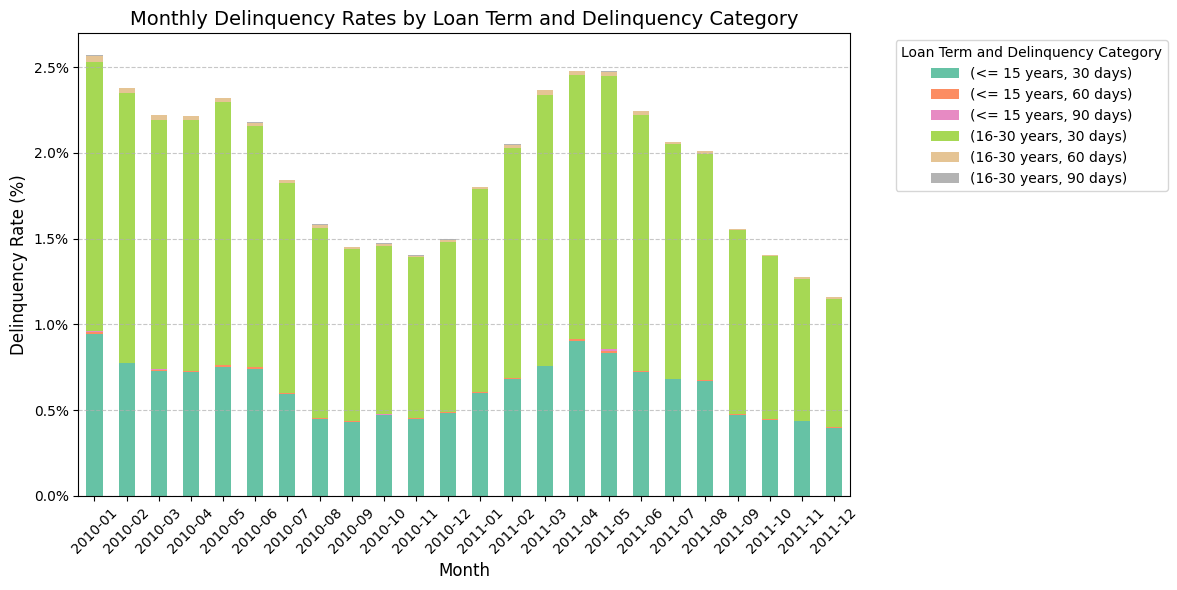

In [ ]:
# Collect data from Spark DataFrame
data = ordered_df.toPandas()

# Pivot the data to create a format suitable for stacked bar chart
pivot_data = data.pivot(index='month', columns=['loan_term_group', 'delinq_category'], values='delinquency_rate')

# Create a color palette
colors = plt.cm.get_cmap('Set2')(np.linspace(0, 1, len(pivot_data.columns)))

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
pivot_data.plot(kind='bar', stacked=True, ax=ax, color=colors)

# Customize the chart
plt.title('Monthly Delinquency Rates by Loan Term and Delinquency Category', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Delinquency Rate (%)', fontsize=12)
plt.legend(title='Loan Term and Delinquency Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust y-axis to percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y * 100)))

# Show the plot
plt.show()

1. Delinquency Rates Over Time:
  - Early 2010 and early 2011 show the highest delinquency rates, with a peak in delinquency rates around the first few months of both years.
  - The delinquency rates gradually decline in the later months of each year.
2. Loan Term Impact:
  - Loans with a term of 16-30 years generally have higher delinquency rates across all categories (30, 60, and 90 days) compared to loans with a term of ≤ 15 years.
  - The most common delinquency category for both loan term groups is 30 days delinquent, with relatively smaller percentages for 60 and 90 days delinquent.
3. Yearly Patterns:
  - There is a noticeable increase in delinquency rates in the early months of both years, with May 2011 showing the highest combined delinquency rates. The rates then taper off toward the end of each year.

# Visualisation of the poor, fair good, very good, and excellent credit score with a mortgage per state for first time buyers.

1. Data Filtering:
The dataset was filtered to include only loans where the borrower is a first-time homebuyer (first_time_buyer == 'Y').
2. Credit Score Classification:
A function classify_credit_score was defined to categorize borrower credit scores into five categories: Poor, Fair, Good, Very Good, and Excellent, based on standard credit score ranges.
3. Data Grouping:
The data was grouped by property_state and Credit Category, and the count of loans for each credit category per state was calculated.
4. Pivot Table Creation:
The grouped data was pivoted to create columns for each credit score category, ensuring the data was structured for visualization. Missing values were filled with zero.
5. Visualization:
A stacked bar chart was generated using the Pandas DataFrame, showing the distribution of credit score categories for first-time buyers by state. Different colors were used to represent each credit score category.

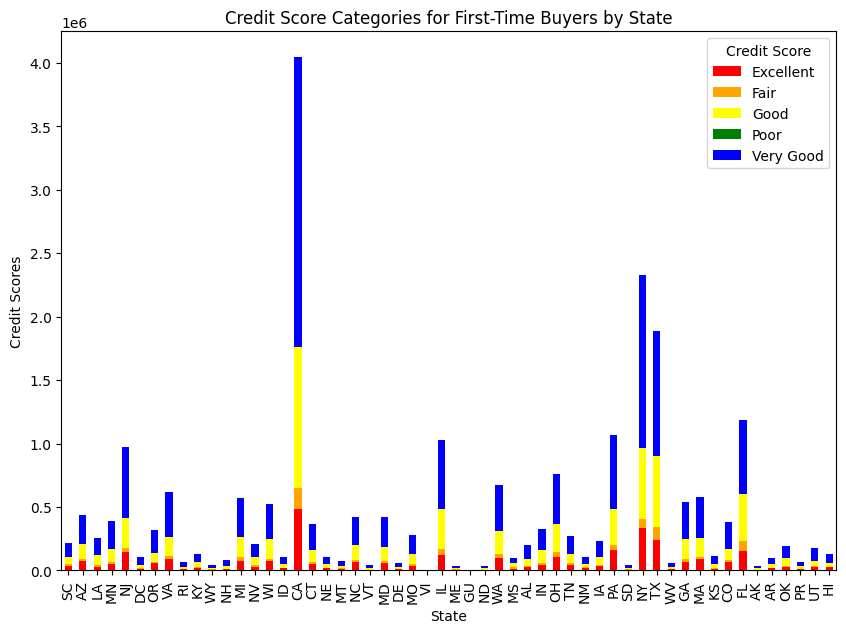

In [ ]:
# Filter for first-time home buyers
first_time_buyers = combined_df.filter(combined_df['first_time_buyer'] == 'Y')

def classify_credit_score(score):
    if score is None or score == "":
        return 'Unknown'
    if score < 580:
        return 'Poor'
    elif 580 <= score < 670:
        return 'Fair'
    elif 670 <= score < 740:
        return 'Good'
    elif 740 <= score < 800:
        return 'Very Good'
    else:
        return 'Excellent'

# Apply the classification
df_with_credit_category = first_time_buyers.withColumn('Credit Category', F.udf(classify_credit_score)(first_time_buyers['borrower_credit_score_orig']))
df_with_credit_category = df_with_credit_category.filter(F.col("Credit Category").isin(["Poor", "Fair", "Good", "Very Good", "Excellent"]))

credit_score_by_state = df_with_credit_category.groupBy('property_state', 'Credit Category').count()


pivot_data = credit_score_by_state.groupBy('property_state').pivot('Credit Category').sum('count').fillna(0)


# Convert to Pandas DataFrame for visualization
pivot_df = pivot_data.toPandas()

# Plot stacked bar chart
pivot_df.set_index('property_state').plot(kind='bar', stacked=True, figsize=(10, 7),
                                          color=['red', 'orange', 'yellow', 'green', 'blue'])
plt.title('Credit Score Categories for First-Time Buyers by State')
plt.xlabel('State')
plt.ylabel('Credit Scores')
plt.legend(title='Credit Score')
plt.show()


The stacked bar chart illustrates the distribution of credit scores (Poor, Fair, Good, Very Good, Excellent) among first-time homebuyers for each state.
In most states, the "Very Good" credit score category (blue) dominates the distribution, especially in states like California (CA) and Texas (TX).
Fair and Good scores (orange and yellow) are present in smaller proportions, and Excellent credit scores (red) are minimal in most states. Poor credit scores (green) are not seen in any of the states which depicts that loans are not issued for poor credit scores.

# Analysis of the correlations between the FICO Score, LTV Ratio, and Interest Rate with the loan status

1. Data Selection:
Selected relevant columns: FICO Score, LTV Ratio, Interest Rate, and Loan Status.
2. Loan Status Categorization:
  - A UDF was used to categorize the loan delinquency status into three categories:
    - 1 for current loans,
    - 2 for loans delinquent by 1-90 days, and
    - 3 for loans defaulted loans.
3. Feature Assembly:
The selected columns were transformed into a feature vector using VectorAssembler, which is required for correlation analysis.
4. Correlation Matrix:
The correlation between FICO Score, LTV Ratio, Interest Rate, and Loan Status Index was computed using PySpark's Correlation.corr() function, and the resulting correlation matrix was converted into a Pandas DataFrame for visualization.
5. Visualization:
A heatmap was created to visualize the correlation matrix using seaborn, with color-coded intensity representing the strength and direction of correlations.

                   FICO Score  LTV Ratio  Interest Rate  Loan Status Index
FICO Score           1.000000  -0.126583      -0.241245          -0.106853
LTV Ratio           -0.126583   1.000000       0.237023           0.024518
Interest Rate       -0.241245   0.237023       1.000000           0.056055
Loan Status Index   -0.106853   0.024518       0.056055           1.000000


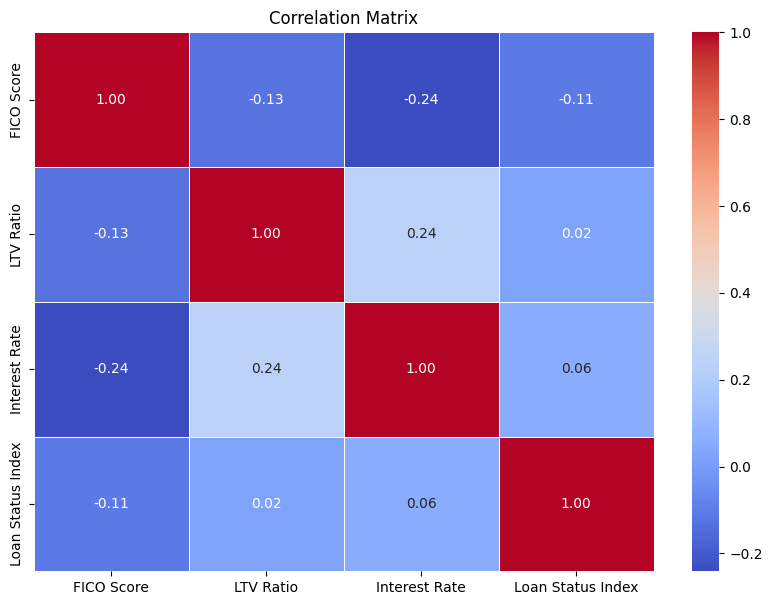

'\n# Index the Loan Status column\nindexer = StringIndexer(inputCol="Loan Status", outputCol="Loan Status Index")\ndf_indexed = indexer.fit(df_filtered).transform(df_filtered)\n\n# Convert to Pandas DataFrame for correlation analysis\npandas_df = df_indexed.toPandas()\n\n# # Calculate correlations\n# correlations = pandas_df[[\'FICO Score\', \'LTV Ratio\', \'Interest Rate\', \'Loan Status Index\']].corr()\n# print(correlations)\n\n\n# plt.figure(figsize=(10, 7))\n# sns.heatmap(correlations, annot=True, cmap=\'coolwarm\', fmt=\'.2f\', linewidths=0.5)\n# plt.title(\'Correlation Matrix\')\n# plt.show()\n\n\n'

In [ ]:
# Select relevant columns
df_filtered = combined_df.select(
    col("borrower_credit_score_orig").alias("FICO Score"),
    col("orig_ltv").alias("LTV Ratio"),
    col("orig_int_rate").alias("Interest Rate"),
    col("curr_loan_delinq_status")
)

# Function to categorize delinquency
def loan_status(delinq):
  if delinq is None or delinq == "":
        return 0
  if delinq == "XX":
        return 0
  delinq_int = int(delinq)
  if(delinq_int == 0):
    return int(1)
  elif(delinq_int > 1 and delinq_int <= 90):
    return int(2)
  else:
    return int(3)

loan_status_udf = F.udf(loan_status, StringType())

# Add delinquency category column
df_filtered = df_filtered.withColumn("Loan Status Index", loan_status_udf(F.col("curr_loan_delinq_status")))
df_filtered = df_filtered.filter(F.col("Loan Status Index").isin([1,2,3]))

# Handle missing values (drop)
df_filtered = df_filtered.dropna()


# Assemble the feature columns into a single vector column
assembler = VectorAssembler(
    inputCols=['FICO Score', 'LTV Ratio', 'Interest Rate', 'Loan Status Index'],
    outputCol='features'
)

# Convert the columns to the correct data types
df_filtered = df_filtered.withColumn("Loan Status Index", F.col("Loan Status Index").cast(IntegerType()))

df_assembled = assembler.transform(df_filtered)

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_assembled, 'features').head()[0]
corr_matrix = correlation_matrix.toArray()

# Print the correlation matrix
corr_df = pd.DataFrame(corr_matrix,
                       columns=['FICO Score', 'LTV Ratio', 'Interest Rate', 'Loan Status Index'],
                       index=['FICO Score', 'LTV Ratio', 'Interest Rate', 'Loan Status Index'])

print(corr_df)

plt.figure(figsize=(10, 7))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


- FICO Score:
    - There is a negative correlation between FICO Score and both Interest Rate (-0.24) and Loan Status Index (-0.11), meaning borrowers with higher FICO scores tend to have lower interest rates and are less likely to default or become delinquent.

- LTV Ratio:
    - There is a positive correlation between LTV Ratio and Interest Rate (0.24), indicating that loans with higher loan-to-value ratios tend to have higher interest rates.
    - The correlation between LTV Ratio and Loan Status Index is very weak (0.02), suggesting that LTV Ratio does not have a strong impact on loan delinquency.

- Interest Rate:
    - The Interest Rate has a weak positive correlation with Loan Status Index (0.06), implying that higher interest rates are slightly associated with a higher likelihood of delinquency.

# Distribution of FICO Scores, LTV Ratios, and Interest Rates across different loan statuses (performing, delinquent, defaulted).

1. Data Cleaning:
The dataset was filtered to remove null values and rows with undefined delinquency status (i.e., XX or null values).
2. Loan Status Categorization:
Loans were categorized into Performing, Delinquent (1-90 days past due), and Defaulted (more than 90 days past due) based on their delinquency status.
3. Credit Score Selection:
The borrower credit score was used if available, otherwise, the co-borrower credit score was taken. This ensured that we had a credit score for each loan.
4. Aggregation:
For each loan status (Performing, Delinquent, Defaulted), the mean and standard deviation of FICO scores, LTV ratios, and Interest rates were calculated.
5. Density Plot Visualization:a
A series of density plots were created for FICO score, LTV ratio, and Interest rate distributions across the three loan statuses. The distributions show how these features vary for performing, delinquent, and defaulted loans.

In [ ]:
# First, remove XX and NULL values from curr_loan_delinq_status
df_cleaned = combined_df.filter(
    (F.col("curr_loan_delinq_status").isNotNull()) &
    (F.col("curr_loan_delinq_status") != "XX")
)

# Define loan status and select relevant columns
df_processed = df_cleaned.select(
    F.col("borrower_credit_score_orig").alias("fico_score"),
    F.col("co_borrower_credit_score_orig").alias("co_fico_score"),
    F.col("orig_ltv").cast(DoubleType()).alias("ltv_ratio"),
    F.col("orig_int_rate").cast(DoubleType()).alias("interest_rate"),
    F.col("curr_loan_delinq_status").cast(DoubleType()).alias("delinq_status")
).withColumn(
    "loan_status",
    F.when(F.col("delinq_status") == 0, "Performing")
    .when((F.col("delinq_status") > 0) & (F.col("delinq_status") <= 90), "Delinquent")
    .when(F.col("delinq_status") > 90, "Defaulted")
    .otherwise("Other")
)

# Determine credit score to use, preferring borrower's score but using co-borrower's if borrower's is empty
df_final = df_processed.withColumn(
    "credit_score",
    F.when(F.col("fico_score").isNotNull() & (F.col("fico_score") != ""), F.col("fico_score"))
    .otherwise(F.col("co_fico_score"))
).select(
    F.col("credit_score").cast(DoubleType()),
    F.col("ltv_ratio"),
    F.col("interest_rate"),
    "loan_status"
)

# Filter out null values
df_filtered = df_final.dropna()

# Encode loan status numerically
df_encoded = df_filtered.withColumn(
    "loan_status_numeric",
    F.when(F.col("loan_status") == "Performing", 1)
    .when(F.col("loan_status") == "Delinquent", 2)
    .when(F.col("loan_status") == "Defaulted", 3)
    .otherwise(0)  # for "Other"
)

# Prepare data for correlation analysis
assembler = VectorAssembler(
    inputCols=["credit_score", "ltv_ratio", "interest_rate", "loan_status_numeric"],
    outputCol="features"
)
df_vector = assembler.transform(df_encoded)

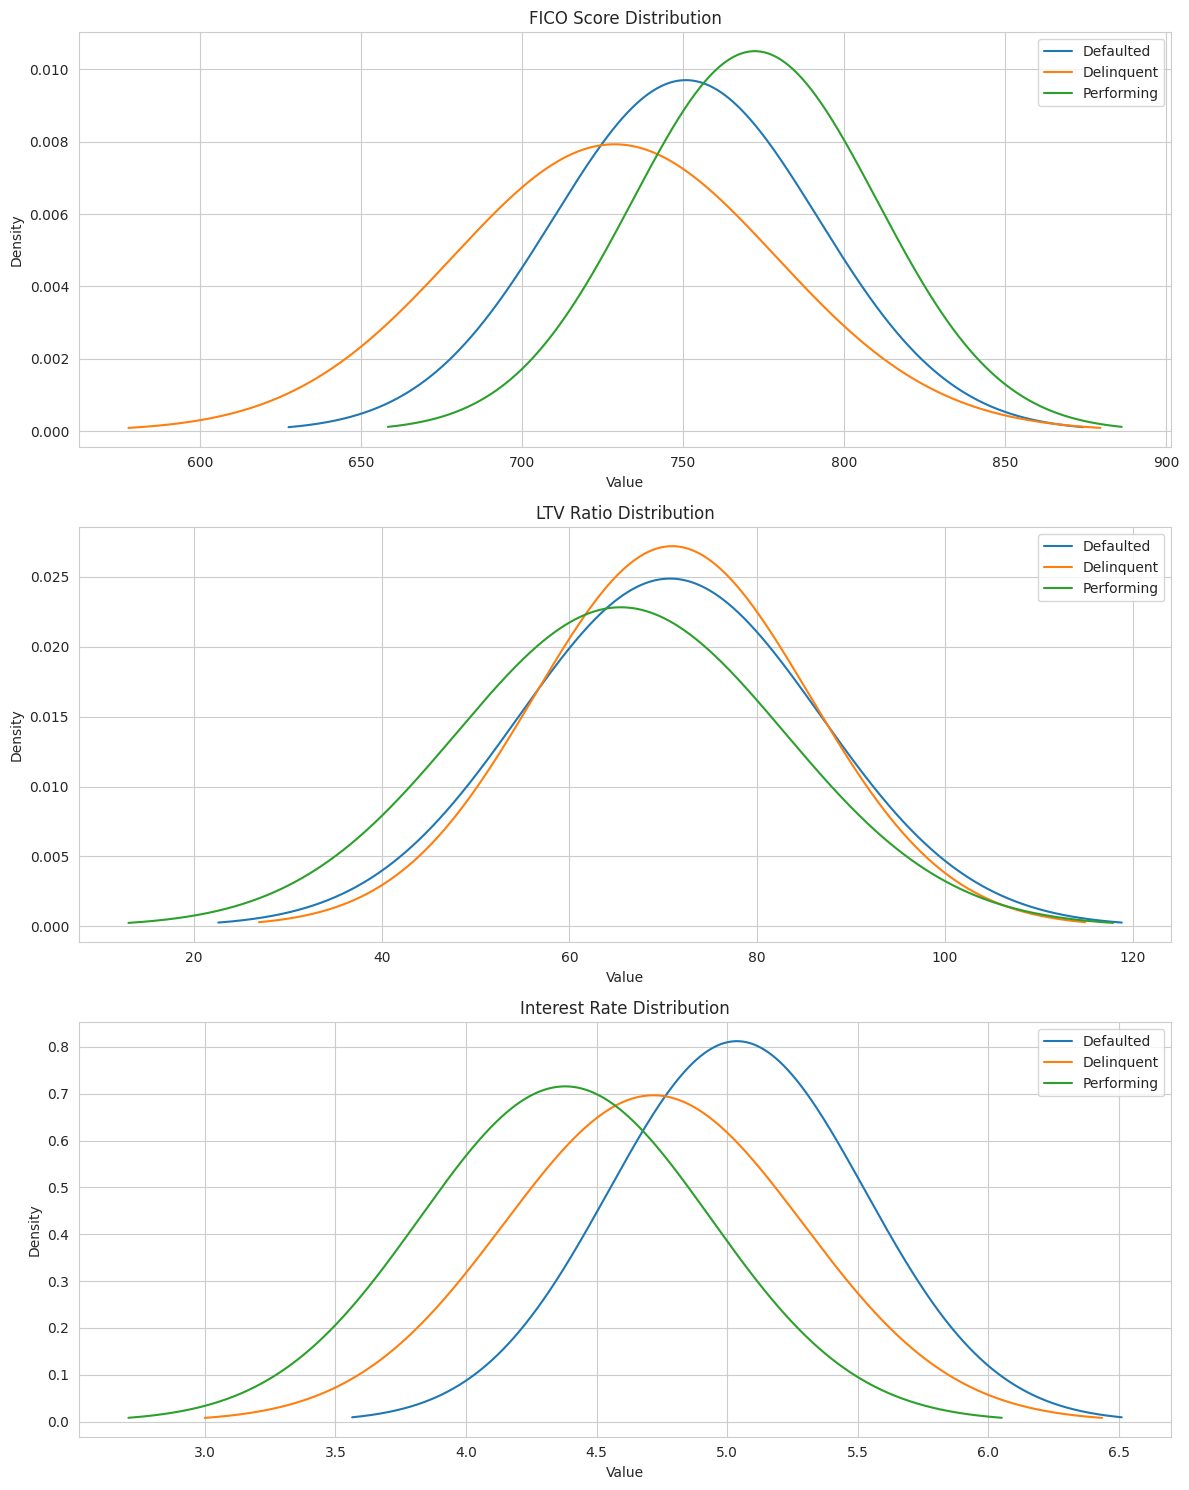

In [ ]:
df_encoded = df_encoded.na.drop(subset=["credit_score", "ltv_ratio", "interest_rate"])
# Aggregating data
agg_df = df_encoded.groupBy("loan_status").agg(
    F.mean("credit_score").alias("mean_fico_score"),
    F.stddev("credit_score").alias("std_fico_score"),
    F.mean("ltv_ratio").alias("mean_ltv_ratio"),
    F.stddev("ltv_ratio").alias("std_ltv_ratio"),
    F.mean("interest_rate").alias("mean_interest_rate"),
    F.stddev("interest_rate").alias("std_interest_rate")
).toPandas()

def create_density_plot(data, feature, ax, title):
    for status, color in zip(data['loan_status'].unique(), ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']):
        subset = data[data['loan_status'] == status]
        mean = subset[f'mean_{feature}'].values[0]
        std = subset[f'std_{feature}'].values[0]
        x = np.linspace(mean - 3*std, mean + 3*std, 1000)
        y = norm.pdf(x, mean, std)
        ax.plot(x, y, label=status, color=color)

    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

# Set up the plot style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 15))

# Create subplots
features = ['fico_score', 'ltv_ratio', 'interest_rate']
titles = ['FICO Score Distribution', 'LTV Ratio Distribution', 'Interest Rate Distribution']

for i, (feature, title) in enumerate(zip(features, titles)):
    ax = plt.subplot(3, 1, i+1)
    create_density_plot(agg_df, feature, ax, title)

plt.tight_layout()
plt.show()

- FICO Score Distribution:
    - Performing loans tend to have higher FICO scores, with a peak around 750-800.
    - Delinquent loans show a lower peak around 700, and Defaulted loans have even lower scores with a peak around 650.
    - This indicates that borrowers with lower FICO scores are more likely to default or become delinquent.
- LTV Ratio Distribution:
    - The LTV ratios for all loan statuses have similar distributions, with peaks around 70-80%. However, defaulted loans tend to have slightly higher LTV ratios, which may indicate higher risk associated with loans where borrowers have less equity in their properties.
- Interest Rate Distribution:
    - Performing loans generally have lower interest rates, peaking around 4.5%.
    - Delinquent and Defaulted loans have higher interest rates, with peaks around 5.0% and 5.5%, respectively, suggesting that higher interest rates may contribute to higher default risk.

# Comparision of the default rates for loans originated in different quarters to assess if default risk has changed over time.

1. Date and Loan Status Processing:
  - The loan origination date was used to classify each loan into quarters (e.g., Q1, Q2).
  - The loan delinquency status was categorized into "Performing", "Delinquent", or "Defaulted" based on the loan's delinquency status.
2. Data Grouping and Default Rate Calculation:
  - Loans were grouped by quarter and loan status, with counts for each loan status (performing, delinquent, defaulted) per quarter.
  - The default rate was calculated by dividing the number of defaulted loans by the total number of loans in each quarter.
3. Visualization:
  - A bar chart was generated to show the default rate for each quarter, from 2010 Q1 to 2011 Q4.

+-------+-------------------+
|quarter|       default_rate|
+-------+-------------------+
| 2010Q1| 0.6864140164234367|
| 2010Q2| 0.6653800889517751|
| 2010Q3| 0.4938211252078609|
| 2010Q4|0.43942972425344745|
| 2011Q1| 0.6008946487853949|
| 2011Q2| 0.7004218525923522|
| 2011Q3| 0.5385783680687385|
| 2011Q4| 0.4022222058979679|
+-------+-------------------+



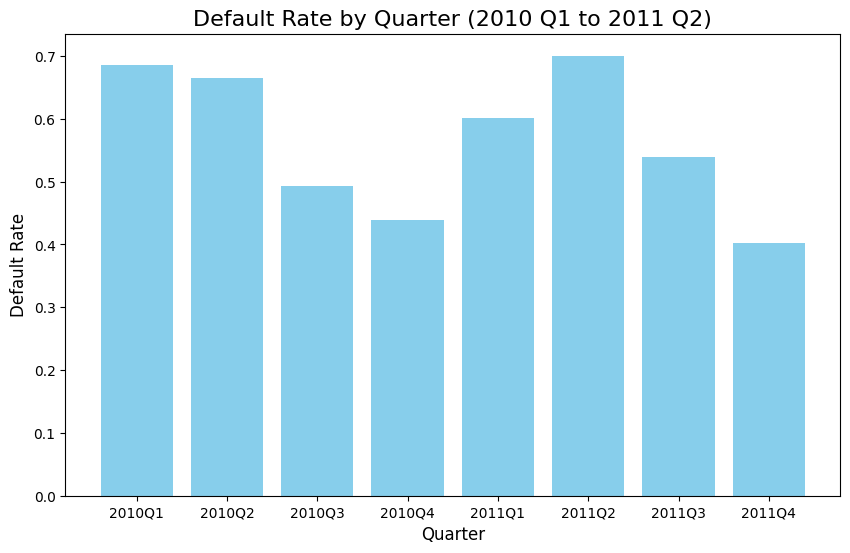

In [ ]:

default_rates = combined_df.select(["orig_date", "curr_loan_delinq_status"])

def set_quarter(orig_date):
    if orig_date is None:
        return None
    month = orig_date // 10000
    year = orig_date % 10000
    if(month >= 1 and month <= 3):
        return f"{year}Q1"
    elif(month >= 4 and month <= 6):
        return f"{year}Q2"
    elif(month >= 7 and month <= 9):
        return f"{year}Q3"
    else:
        return f"{year}Q4"

set_quarter_udf = F.udf(set_quarter, StringType())

# Function to categorize delinquency
def loan_status(delinq):
  if delinq is None or delinq == "":
        return "Removed"
  if delinq == "XX":
        return "Unknown"
  delinq_int = int(delinq)
  if(delinq_int == 0):
    return "Performing"
  elif(delinq_int > 1 and delinq_int <= 90):
    return "Delinquent"
  else:
    return "Defaulted"
loan_status_udf = F.udf(loan_status, StringType())


default_rates = default_rates.withColumn("quarter", set_quarter_udf(F.col("orig_date")))
default_rates = default_rates.withColumn("Loan Status", loan_status_udf(F.col("curr_loan_delinq_status")))
default_rates = default_rates.filter(F.col("quarter").isin(["2010Q1", "2010Q2", "2010Q3", "2010Q4", "2011Q1", "2011Q2", "2011Q3", "2011Q4"]))

# Group by quarter and loan status to count the number of each loan status per quarter
status_counts = default_rates.groupBy("quarter", "Loan Status").count()

# Calculate the total loans per quarter
total_loans_per_quarter = default_rates.groupBy("quarter").count().withColumnRenamed("count", "total_loans")

# Join the counts of loan statuses with the total loans per quarter
default_rate_calc = status_counts.join(total_loans_per_quarter, on="quarter")

# Calculate default rate (only for 'Defaulted' loans)
default_rate_calc = default_rate_calc.withColumn(
    "default_rate",
    F.when(F.col("Loan Status") == "Defaulted", (F.col("count") / F.col("total_loans")) * 100)
).filter(F.col("Loan Status") == "Defaulted")

# Define sorting logic for quarter
default_rate_calc = default_rate_calc.withColumn(
    "quarter ind",
    F.when(F.col("quarter") == "2010Q1", 1)
     .when(F.col("quarter") == "2010Q2", 2)
     .when(F.col("quarter") == "2010Q3", 3)
     .when(F.col("quarter") == "2010Q4", 4)

     .when(F.col("quarter") == "2011Q1", 5)
     .when(F.col("quarter") == "2011Q2", 6)
     .when(F.col("quarter") == "2011Q3", 7)
     .when(F.col("quarter") == "2011Q4", 8)

)

# Apply ordering by month, loan_term_group_order, and delinq_category_order
default_rate_calc = default_rate_calc.orderBy(
    F.col("quarter ind").asc()
)

# Show the result
default_rate_calc.select("quarter", "default_rate").show()

default_rate_df = default_rate_calc.select("quarter", "default_rate").toPandas()

# Filter the required quarters (2010 Q1 to 2011 Q2)
quarters_order = ['2010Q1', '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4']
# default_rate_df = default_rate_df[default_rate_df['quarter'].isin(quarters_order)]

# Plotting the default rates for each quarter
plt.figure(figsize=(10, 6))
plt.bar(default_rate_df['quarter'], default_rate_df['default_rate'], color='skyblue')

# Adding titles and labels
plt.title("Default Rate by Quarter (2010 Q1 to 2011 Q2)", fontsize=16)
plt.xlabel("Quarter", fontsize=12)
plt.ylabel("Default Rate", fontsize=12)

# Display the plot
plt.show()

- The default rate fluctuates significantly across the quarters:

  - The highest default rate occurs in 2011 Q2 at 0.70, indicating that 70% of loans originated in this quarter defaulted.
  - 2010 Q1 and 2010 Q2 also have high default rates, above 0.65.
The default rate decreases in 2010 Q3 and 2010 Q4, reaching a low of 0.44 in 2010 Q4.
  - After peaking in 2011 Q2, the default rate declines again in 2011 Q4 to 0.40.

# Recovery of Loan after defauting the accounts


1. Data Selection:
The relevant columns curr_loan_delinq_status, orig_upb (original unpaid principal balance), foreclosure_costs, and upb_at_removal were selected for calculating the loan recovery percentage.
2. Loan Status Filtering:
A UDF was applied to categorize loans based on their delinquency status, and only loans that are 90+ days delinquent (representing defaulted loans) were selected.
3. Filtering for Valid Data:
Rows where either upb_at_removal or original unpaid principal balance (orig_upb) were missing were filtered out to ensure the calculations only used valid data.
4. Recovery Percentage Calculation:
The recovery percentage was calculated using the formula:

        ( (UPB at Removal - Foreclosure Costs) / Original UPB) * 100

This calculation gives the percentage of the loan amount recovered after accounting for the foreclosure costs.
5. Aggregation:
The average recovery percentage across all defaulted loans was computed using PySpark's aggregation functions.

In [ ]:
recovery_df = combined_df.select("curr_loan_delinq_status", "orig_upb", "foreclosure_costs", "upb_at_removal")

recovery_df = recovery_df.withColumn("Loan Status", categorize_delinquency_udf(col("curr_loan_delinq_status")))
recovery_df = recovery_df.filter(col("Loan Status") == "90+ days").limit(30000)

recovery_df = recovery_df.filter(
    col("foreclosure_costs").isNotNull() &
    col("upb_at_removal").isNotNull() &
    col("orig_upb").isNotNull()
)

recovery_df = recovery_df.withColumn("Recovery Percentage", ((col("upb_at_removal") - col("foreclosure_costs"))/col("orig_upb"))*100)

average_recovery_rate = recovery_df.agg(
    F.mean("Recovery Percentage").alias("Average Recovery Percentage")
)

average_recovery_rate.cache()
avg_per = average_recovery_rate.collect()[0]["Average Recovery Percentage"]
average_recovery_rate.unpersist()

print("Percentage of the loan amount recovered after default:", avg_per)


Percentage of the loan amount recovered after default: 77.42101739822363


The output indicates that the average recovery percentage after default is approximately 77.42%. This means that on average, 77.42% of the original unpaid principal balance (UPB) is recovered after accounting for foreclosure costs and UPB at the time of removal.

This result suggests that a significant portion of the loan amount is typically recovered even after default, although foreclosure costs reduce the total recovery slightly.

# Average, Median, and Variance of property price changes over the entire duration, bucketed by month.

1. Data Selection:
Columns curr_list_start_date, curr_list_price, and orig_list_price were selected to calculate property price changes over time.
2. Filtering and Cleaning:
Rows where any of these columns contained null or empty values were filtered out to ensure valid data for analysis.
3. Date Conversion:
The curr_list_start_date was converted to a date format to extract the year and month for bucketing the price changes by month.
4. Price Change Calculation:
The percentage change in property price was calculated as:

        ((|Current List Price - Original List Price|)/Original List) * 100

This calculation aimed to capture how much property prices have changed over time.
5. Aggregation:
The data was grouped by year and month, and the average, median, and variance of the property price changes were calculated for each month.
6. Visualization:
A line plot was generated to show the average, median, and variance of price changes over time, allowing for an analysis of property price volatility and trends.

In [ ]:
stats_df = combined_df.select("curr_list_start_date", "curr_list_price", "orig_list_price")

# Drop rows where any of the columns are null, None, or empty
stats_df = stats_df.filter(
    col("curr_list_start_date").isNotNull() &
    (col("curr_list_start_date") != "") &
    col("curr_list_price").isNotNull() &
    (col("curr_list_price") != "") &
    col("orig_list_price").isNotNull() &
    (col("orig_list_price") != "")
)

stats_df = stats_df.withColumn("curr_list_start_date", to_date(int_to_date_udf(col("curr_list_start_date"))))

# Calculate the property price change (Current List Price - Original List Price)/Original List Price * 100
stats_df = stats_df.withColumn("Price_Change", (abs(col("curr_list_price") - col("orig_list_price"))/col("orig_list_price"))*100 )

# Extract year and month from the 'Current List Start Date' to bucket the data by month
stats_df = stats_df.withColumn("Year", year(col("curr_list_start_date"))).withColumn("Month", month(col("curr_list_start_date")))

# Group by year and month, and calculate the average, median, and variance of price changes
stats_df = stats_df.groupBy("Year", "Month").agg(
    avg("Price_Change").alias("Avg_Price_Change"),
    percentile_approx("Price_Change", 0.5).alias("Median_Price_Change"),
    variance("Price_Change").alias("Variance_Price_Change")
)

# Sort the results by Year and Month
stats_df = stats_df.orderBy("Year", "Month")

In [ ]:
# Show the results
# stats_df.head(10)

# Convert the results to Pandas DataFrame for plotting
stats_df = stats_df.toPandas()

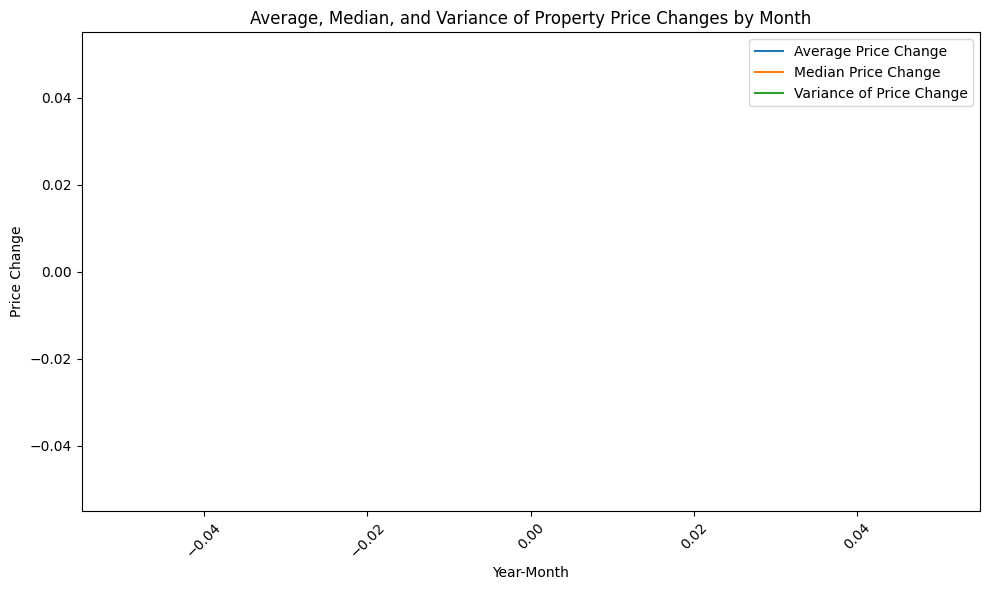

In [ ]:
# Set up the figure and axis
plt.figure(figsize=(10,6))

# Plot average price change
plt.plot(stats_df['Year'].astype(str) + '-' + stats_df['Month'].astype(str), stats_df['Avg_Price_Change'], label='Average Price Change')

# Plot median price change
plt.plot(stats_df['Year'].astype(str) + '-' + stats_df['Month'].astype(str), stats_df['Median_Price_Change'], label='Median Price Change')

# Plot variance of price change
plt.plot(stats_df['Year'].astype(str) + '-' + stats_df['Month'].astype(str), stats_df['Variance_Price_Change'], label='Variance of Price Change')

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Price Change')
plt.title('Average, Median, and Variance of Property Price Changes by Month')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


The plot is empty because all the columns (curr_list_start_date, curr_list_price, and orig_list_price) contain null values. Since there is no valid data for these fields, the plot doesn't display any price changes.

This means there is no available data in the dataset for property price changes over time, which might be due to missing or incomplete data in the relevant fields.